In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
from keras.datasets import mnist
import keras.backend as K
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, Lambda,ELU,Activation, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
import keras.losses as losses
import keras.objectives as objectives
from keras.optimizers import Adam,SGD,RMSprop
import keras.metrics as metrics
from keras.models import Model
from functools import reduce
from operator import mul
from sklearn.model_selection import train_test_split
from ipywidgets import interact
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import ipywidgets as ipy
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU
import numpy as np
from IPython.display import SVG
import pandas as pd
import numpy as np
import imageio
import os
from skimage import io, color
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot, plot_model

%matplotlib inline

/home/qati/.anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def load_data(data_dir, csv_file):
    df = pd.read_csv(csv_file)
    faces = os.listdir(data_dir)
    X = np.zeros((len(faces), 48,48))
    Y = np.zeros((len(faces), 1))
    for face in faces:
        fid = int(face.replace(".png",""))
        X[fid-1,:,:] = np.array(imageio.imread(data_dir+face))[:,:,0]/255.
        Y[fid-1, 0]  = int(df.loc[df["ID"]==int(fid)]["isHappy"].values)
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.1, random_state=4325524)
    return (X_train,Y_train, X_validation, Y_validation)

In [4]:
x_train, y_train, x_dev, y_dev = load_data("../faces/trainData/", "../faces/train_labels.csv")

In [5]:
X_train  = x_train.reshape((-1,48,48,1))
X_dev = x_dev.reshape((-1,48,48,1))

array([0.])

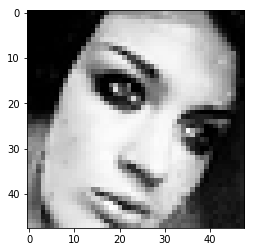

In [6]:
idx = 4
plt.imshow(x_train[idx,:,:], cmap="gray")
y_train[idx,:]

In [7]:
def sampling(latent_dim):
    def wrapper(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(z_log_sigma) * epsilon
    return wrapper

def conv(filters, kernel=5, strides=2, padding="same", lrelu=0.1):
    def run(vol):
        x = Conv2D(filters, kernel, strides=strides, padding=padding)(vol)
        x = BatchNormalization()(x)
        x = LeakyReLU(lrelu)(x)
        return x
    return run

def deconv(filters, kernel=5, strides=2, padding="same", lrelu=0.1):
    def run(vol):
        x = Conv2DTranspose(filters, kernel, strides=strides, padding=padding)(vol)
        x = BatchNormalization()(x)
        x = LeakyReLU(lrelu)(x)
        return x
    return run

def build_vae(input_shape,latent_dim=64):
    
    #encoder
    pic = Input(shape=input_shape)
    
    x = conv(64)(pic)
    x = conv(128)(x)
    x = conv(256)(x)
    x = conv(512)(x)
    x = conv(512, kernel=2)(x)
    x = Reshape((-1,))(x)
    
    z_mean = Dense(latent_dim)(x)
    z_log_sigma = Dense(latent_dim)(x)

    encoder = Model(inputs=[pic], outputs=[z_mean, z_log_sigma])
    encoder.summary()
    
    #decoder
    z_mean_d  = Input((latent_dim,))
    z_log_std_d = Input((latent_dim,))
    z = Lambda(sampling(latent_dim))([z_mean_d, z_log_std_d])
    x = Dense(512*3*3)(z)
    x = Reshape((3,3,512))(x)
    x = BatchNormalization()(x)
    x = deconv(512, kernel=3)(x)
    x = deconv(128)(x)
    x = deconv(64)(x)
    x = Conv2DTranspose(1, kernel_size=7, strides=2, padding="same", activation="sigmoid")(x)

    decoder = Model(inputs=[z_mean_d, z_log_std_d], outputs=[x])
    
    print(decoder.summary())

    #autoencoder
    autoencoder = Model(inputs=[pic], outputs=decoder(encoder.output))    
    
    return encoder, decoder, autoencoder

In [8]:
def vae_loss(encoder):
    z_mean, z_log_sigma = encoder.output
    def run(x, z_decoded):
        x = K.batch_flatten(x)
        z_decoded = K.batch_flatten(z_decoded)
        bl_loss = objectives.binary_crossentropy(x, z_decoded)
        kl_loss = - 5e-4 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return K.mean(bl_loss + kl_loss)
    return run

In [9]:
encoder, decoder, autoencoder = build_vae([48,48,1], latent_dim=400)
autoencoder.compile(loss=vae_loss(encoder), optimizer=Adam(0.0004, beta_1=0.9, decay=1e-5))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 24, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 24, 24, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
#save = ModelCheckpoint("vae_faces_2.h5", monitor='loss', verbose=0, save_best_only=True,period=10)
#history = autoencoder.fit(X_train, X_train,  epochs=400, batch_size=256, callbacks=[save])

Epoch 1/400
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6404
Epoch 2/400
9000/9000 [==============================] - 8s 879us/step - loss: 0.5767
Epoch 3/400
9000/9000 [==============================] - 8s 879us/step - loss: 0.5532
Epoch 4/400
9000/9000 [==============================] - 8s 880us/step - loss: 0.5398
Epoch 5/400
9000/9000 [==============================] - 8s 881us/step - loss: 0.5320
Epoch 6/400
9000/9000 [==============================] - 8s 877us/step - loss: 0.5276
Epoch 7/400
9000/9000 [==============================] - 8s 880us/step - loss: 0.5237
Epoch 8/400
9000/9000 [==============================] - 8s 881us/step - loss: 0.5216
Epoch 9/400
9000/9000 [==============================] - 8s 881us/step - loss: 0.5196
Epoch 10/400
9000/9000 [==============================] - 9s 1ms/step - loss: 0.5174
Epoch 11/400
9000/9000 [==============================] - 8s 876us/step - loss: 0.5164
Epoch 12/400
9000/9000 [==============================]

9000/9000 [==============================] - 8s 884us/step - loss: 0.4927
Epoch 189/400
9000/9000 [==============================] - 8s 885us/step - loss: 0.4928
Epoch 190/400
9000/9000 [==============================] - 8s 940us/step - loss: 0.4927
Epoch 191/400
9000/9000 [==============================] - 8s 885us/step - loss: 0.4927
Epoch 192/400
9000/9000 [==============================] - 8s 884us/step - loss: 0.4926
Epoch 193/400
9000/9000 [==============================] - 8s 884us/step - loss: 0.4927
Epoch 194/400
9000/9000 [==============================] - 8s 887us/step - loss: 0.4925
Epoch 195/400
9000/9000 [==============================] - 8s 885us/step - loss: 0.4925
Epoch 196/400
9000/9000 [==============================] - 8s 886us/step - loss: 0.4926
Epoch 197/400
9000/9000 [==============================] - 8s 886us/step - loss: 0.4924
Epoch 198/400
9000/9000 [==============================] - 8s 885us/step - loss: 0.4926
Epoch 199/400
9000/9000 [=====================

9000/9000 [==============================] - 8s 884us/step - loss: 0.4907
Epoch 375/400
9000/9000 [==============================] - 8s 886us/step - loss: 0.4908
Epoch 376/400
9000/9000 [==============================] - 8s 886us/step - loss: 0.4906
Epoch 377/400
9000/9000 [==============================] - 8s 884us/step - loss: 0.4906
Epoch 378/400
9000/9000 [==============================] - 8s 885us/step - loss: 0.4906
Epoch 379/400
9000/9000 [==============================] - 8s 885us/step - loss: 0.4906
Epoch 380/400
9000/9000 [==============================] - 8s 939us/step - loss: 0.4908
Epoch 381/400
9000/9000 [==============================] - 8s 886us/step - loss: 0.4907
Epoch 382/400
9000/9000 [==============================] - 8s 889us/step - loss: 0.4907
Epoch 383/400
9000/9000 [==============================] - 8s 885us/step - loss: 0.4906
Epoch 384/400
9000/9000 [==============================] - 8s 886us/step - loss: 0.4907
Epoch 385/400
9000/9000 [=====================

In [10]:
autoencoder.load_weights("./vae_faces.h5")

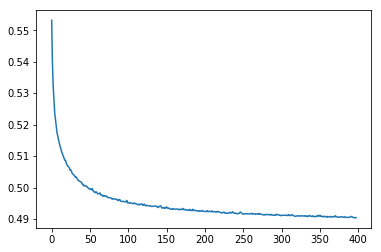

In [19]:
plt.plot(history.history["loss"][2:])

In [11]:
E_test = encoder.predict(X_dev)
D_test = decoder.predict(E_test)

array([0.])

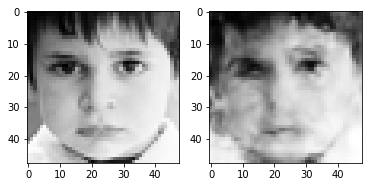

In [12]:
idx = 6

f, (ax1, ax2) = plt.subplots(1, 2)#, sharey=True, sharex=True)
ax1.imshow(x_dev[idx,:,:], cmap="gray")
ax2.imshow(D_test[idx,:,:].reshape((48,48)), cmap="gray")
           
y_dev[idx,:]

In [13]:
happy_z_means, happy_z_stds = encoder.predict(X_dev[(y_dev==1).reshape((-1,))])
happy_z_mean = np.mean(happy_z_means,axis=0, keepdims=True)
happy_z_std  = np.mean(happy_z_stds,axis=0,  keepdims=True)

In [15]:
avg_happy = decoder.predict([happy_z_mean, happy_z_std])

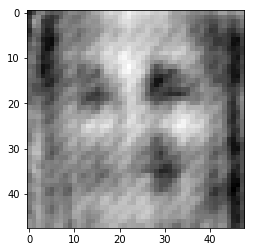

In [16]:
plt.imshow(avg_happy.reshape((48,48)), cmap="gray")

In [17]:
z_means, z_stds = E_test

z_mean = z_means[idx]
z_std  = z_stds[idx]

def plot(x,y):
    mean = x*happy_z_mean+(1-x)*z_mean
    std = y*happy_z_std+(1-y)*z_std
    dec = decoder.predict([mean, std])
    dec = dec.reshape((48,48))
    plt.imshow(dec,cmap="gray")
    plt.show()
    
interact(plot,x=(-1,1,0.01),y=(-1,1,0.01))

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.01), FloatSlider(value=0.0, description='y', max=1.0, min=-1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

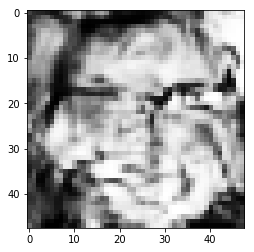

In [18]:
E_rand_mean = np.random.randn(10,400)
E_rand_std  = np.random.randn(10,400)
D_rand = decoder.predict([E_rand_mean, E_rand_std])
D_rand = D_rand.reshape((10,48,48))
plt.imshow(D_rand[6,:,:], cmap="gray")